In [12]:
%matplotlib inline

# Introduction

This notebook tests the new feature "Recobundles" from https://github.com/nipy/dipy/pull/1443#issuecomment-373049087

https://www.sciencedirect.com/science/article/pii/S1053811917305839

## Take 2: Pre-Registration

Added pre-registration to tailor the template to the dataset, and performance improved greatly. The recognized bundles tend to include extra sub-bundles similar to the template. Enforcing single-template membership for each streamline would probably help with this. Refinement of the template would also improve performance; this was using a manually-cleaned single subject as a template. Note: Prisma cases were corrected for susceptibility distortion. The template was made from a case scanned on the Prisma.

Notes from visual inspection (N=1 test brain against N=1 template brain on N=2 scanners):

IFOF
- very good

ILF
- pretty good; a few sub-bundles to clean up (endpoints would help)

UNCINATE
- Some extra sub-bundles, especially short/high turning angle tracks. Frontal targets may help
- There's a debate on what sub-bundles should be included in uncinate... maybe more specific template separating the different components would be helpful
    
ARCUATE/SLF COMPLEX (includes 3 tracks: Arcuate, SLF ip, SLF tp)
- Some mixing SLFip vs. Arcuate vs. SLFtp, but reasonably good performance
    - Differential templates? (enforce single-template membership)
    - Some truncated Arcuate streamlines are included in SLF-ip; enforcing cortical termination may help
- Arcuate low specificity
    - Some Aslant streamlines in Arcuate
    - Some SLF-ip streamlines in Arcuate
    - differential template may help
    - Enforce single-bundle membership
- SLF ip template had a lot of different sub-bundles... other subjects have much more devined models of SLFII and SLFIII... changing the template to one of those may help considerably
- SLF tp has a lot of other sub-bundles; perhaps a differential template?

ASLANT
- pretty good 
- There is an extra branch apparent on the coronal view
- Greater anterior-posterior extent of bundle
    - Differential templates may help to select a particular segment of this larger bundle



NOTES FROM @Garyfallidis

- Pre-registration is assumed

- Pruning threshold most important

- Use multiple streamline distances

# Import/Define Functions

In [189]:
import os
from glob import glob

import nibabel as nib
import numpy as np

from dipy.tracking.distances import bundles_distances_mam
from dipy.tracking.streamline import Streamlines
from dipy.segment.bundles import RecoBundles
from dipy.segment.clustering import qbx_with_merge
from dipy.data import get_data
from dipy.align.streamlinear import whole_brain_slr, slr_with_qb, transform_streamlines


from IPython.display import display, HTML, Image

In [14]:
def make_html(path_list):
    myhtml = ''
    for path in path_list:
        myhtml+='<img src="{}" style="float: left; width: 40%; margin-right: 1%; margin-bottom: 0.5em;"/>'.format(path)
    return myhtml

In [15]:
from dipy.viz import window, actor

def genren(sls, sls2=None, niidata=None, roi1=None, roi2=None, aff=None, putpath=None, show=False, orient=True, colors=[(1,1,1)]):
    
    renderer = window.Renderer()
    
    if len(colors)>1:
        stream_actor = actor.line(sls, colors=colors[1])
    else:
        stream_actor=actor.line(sls)
        
    renderer.add(stream_actor)
    
    if sls2 is not None:
        stream_actor2 = actor.line(sls2, colors=colors[0])
        renderer.add(stream_actor2)
    
    if roi1 is not None and roi2 is not None:
        
        contour_actor1 = actor.contour_from_roi(roi1, affine=aff, color=(1., 1., 0.),
                                          opacity=0.5)
        contour_actor2 = actor.contour_from_roi(roi2, affine=aff, color=(1., 0., 0.),
                                          opacity=0.5)
        renderer.add(contour_actor1)
        renderer.add(contour_actor2)
        
    
    if niidata is not None:
        slice_actor = actor.slicer(niidata, affine=aff)
        renderer.add(slice_actor)

    #renderer.set_camera(position=(-176.42, 118.52, 128.20),
    #                    focal_point=(113.30, 128.31, 76.56),
    #                    view_up=(0.18, 0.00, 0.98))

    if orient:
        axes_actor = actor.axes(scale=(10, 10, 10), colorx=(1, 0, 0), colory=(0, 1, 0), colorz=(0, 0, 1), opacity=1)
        #Create an actor with the coordinate’s system axes where red = x, green = y, blue = z.
        renderer.add(axes_actor)

    if show:
        window.show(renderer, size=(600, 600), reset_camera=False)
    if putpath is not None:
        window.record(renderer, out_path=putpath, size=(600, 600))
    del renderer
    return putpath

In [16]:
def run_rb(templatesls, bucketosls, cluster_map=None):
    if cluster_map is None:
        cluster_map = qbx_with_merge(bucketosls, thresholds=[40, 25, 20, 10])
    else:
        print("Loading provided cluster map")

    rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=5.,
                                                         reduction_thr=10)
    '''rb = RecoBundles(bucketosls, cluster_map=cluster_map, clust_thr=10)
    recognized, rec_labels, rec_trans = rb.recognize(model_bundle=templatesls,
                                                         model_clust_thr=1.)'''
    #D = bundles_distances_mam(templatesls, recognized)
    
    return recognized, cluster_map

In [17]:
def rough_reg(sub_fixed, temp_moving):
    #template moves to the subject space
    #qb_thr=5 errored
    moved, transform, qb_centroids1, qb_centroids2 = whole_brain_slr(sub_fixed, temp_moving, 
                                                                     verbose=True,
                                                                     greater_than=0,
                                                                     less_than=np.inf, 
                                                                     qb_thr=15, 
                                                                     progressive=True)
    return moved, transform, qb_centroids1, qb_centroids2

This is taking a very long time (large datasets)... there is probably a reasonable subsampling that will universally suffice... perhaps reducing the streamline dataset prior to running the quickbundles would help? (maybe a flag that is defaulted to false to specify if the user really wants all streamlines represented?)

# Find paths/load data

In [58]:
putdir = 'output_Kesh_Test_Recobundles_testing'
if not os.path.exists(putdir):
    os.mkdir(putdir)

In [44]:
def loadtgm_newapi(trkpath):
    trkloaded = nib.streamlines.trk.TrkFile.load(trkpath)
    hdrloaded = trkloaded.header
    tg=trkloaded.tractogram
    return tg

Whole brain from Prisma and Trio (same brain)

In [45]:
wb_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob_gt40mm_good.trk'
wb_prisma_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/Whole_Brain_bs_prob.trk'
wb_trio_path_raw = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/Whole_Brain_bs_prob.trk'

#single case gold standard
gs_prisma_path = '/Users/kesshijordan/ref_data/interscan_dys/Prisma/TRACKs/'
gs_trio_path = '/Users/kesshijordan/ref_data/interscan_dys/Trio/TRACKs/'

#single case template
pathpath = '/Users/kesshijordan/paths/recobundles_template_basepath.txt'
with open(pathpath, 'r') as myfile:
    template_basepath = myfile.read().replace('\n', '').replace('\'','')

# Prisma Whole Brain Dataset from Subject

In [21]:
#Nice streamlines
#wb_prisma_tg = loadtgm_newapi(wb_prisma_path)
#wb_prisma_sls = wb_prisma_tg.streamlines

In [22]:
wb_rawprisma_tg = loadtgm_newapi(wb_prisma_path_raw)
wb_rawprisma_sls = wb_rawprisma_tg.streamlines

# Trio Whole Brain Dataset from Subject

In [23]:
wb_rawtrio_tg = loadtgm_newapi(wb_trio_path_raw)
wb_rawtrio_sls = wb_rawtrio_tg.streamlines

# Whole Brain Template 

also from subject on prisma

In [24]:
wb_template = os.path.join(template_basepath, '../Whole_Brain_bs.trk')

wb_template_tg = loadtgm_newapi(wb_template)
wb_template_sls = wb_template_tg.streamlines

# Pre-register using streamlinear registration with wholebrain

In [39]:
short_wb_prisma_sls = wb_rawprisma_sls[::100]
short_wb_trio_sls = wb_rawtrio_sls[::100]
short_wb_template_sls = wb_template_sls[::100]

In [26]:
moved_temp2prisma, xfm_temp2prisma, qbc1_temp2prisma, qbc2_temp2prisma = rough_reg(short_wb_prisma_sls, short_wb_template_sls)

Static streamlines size 65445
Moving streamlines size 53068
Static streamlines after length reduction 39637
Moving streamlines after length reduction 34428
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 382
QB moving centroids size 333
SLR finished in  26.200 seconds.
SLR iterations: 101 


In [27]:
moved_temp2trio, xfm_temp2trio, qbc1_temp2trio, qbc2_temp2trio = rough_reg(short_wb_trio_sls, short_wb_template_sls)

Static streamlines size 45151
Moving streamlines size 53068
Static streamlines after length reduction 32075
Moving streamlines after length reduction 34428
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 314
QB moving centroids size 333
SLR finished in  17.800 seconds.
SLR iterations: 101 


## IFOF

Single case template

NOTE: When I used transform_streamlines, I got an error on recobundles... must be array sequence, NOT list, so the syntax must be mysls.apply_affine(xfm_temp2prisma).streamlines  NOT transform_streamlines(mysls, xfm_temp2trio)

In [68]:
template = os.path.join(template_basepath, 'IFOF_L.trk')

t_tg_ifof = loadtgm_newapi(template)
#t_sls_ifof_noxfm = t_tg_ifof.streamlines
t_sls_ifof_prisma = t_tg_ifof.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ifof_trio = t_tg_ifof.copy().apply_affine(xfm_temp2trio).streamlines

### IFOF Prisma

#### Test Pre-Registration

Before

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


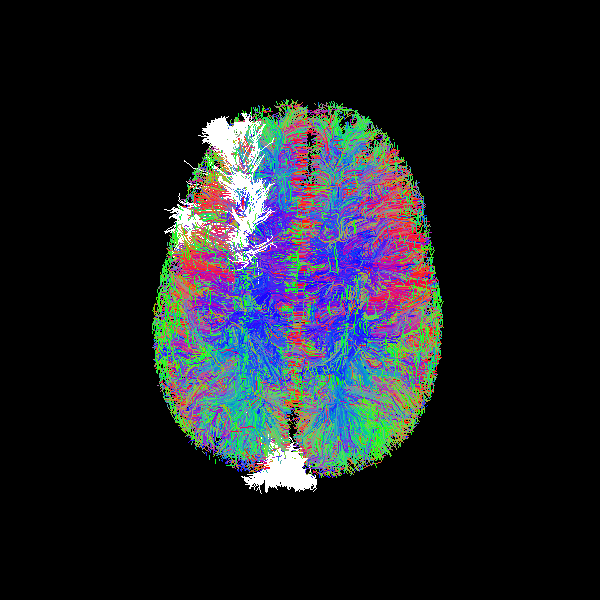

In [76]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_rawprisma_sls[::100], t_tg_ifof.streamlines, putpath=renpath)
Image(renpath, width=400, height=400)

After

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


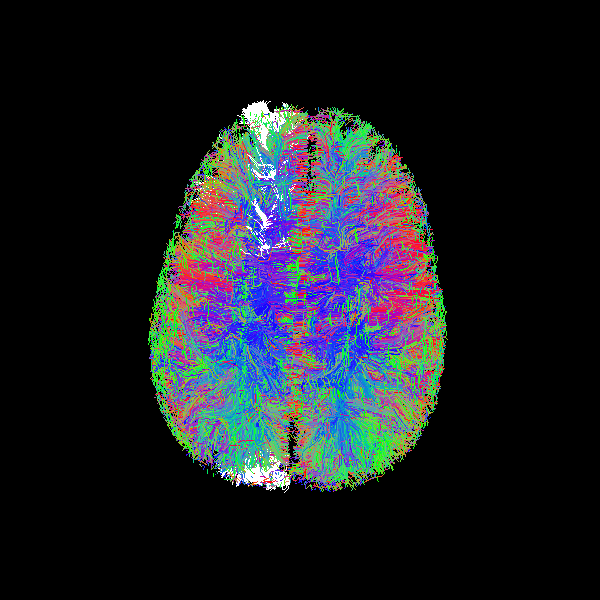

In [77]:
renpath=os.path.join(putdir, 'WB_IFOF_L.png')
genren(wb_rawprisma_sls[::100], t_sls_ifof_prisma, putpath=renpath)
Image(renpath, width=400, height=400)

Find the template IFOF in the whole brain of another patient

In [78]:
rb_prisma_ifof_L, cluster_map_prisma = run_rb(t_sls_ifof_prisma, wb_rawprisma_sls)

 Resampled to 20 points
 Size is 1497.912 MB
 Duration of resampling is 4.890 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 6544476 random streamlines
 Duration 313.708 sec. 

 Streamlines have 6809 centroids
 Total loading duration 0.004 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.015 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.945 sec. 

 Model bundle has 175 centroids
 Duration 0.962 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10815
 Duration 1.902 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.537
 Number of iterations 52
 Matrix size (400, 600)
[[ 1.012 -0.035  0.038  3.496]
 [ 0.032  1.01   0.081  3.743]
 [-0.04

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


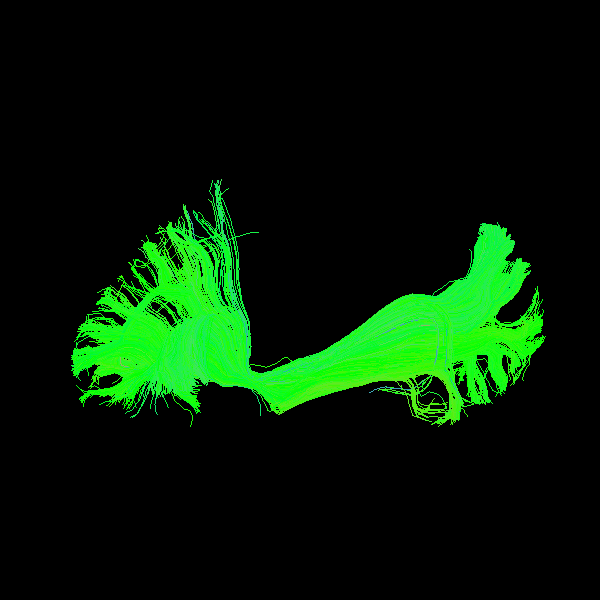

In [177]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

Interestingly, this worked with and without pre-registration

#### Recognized IFOF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


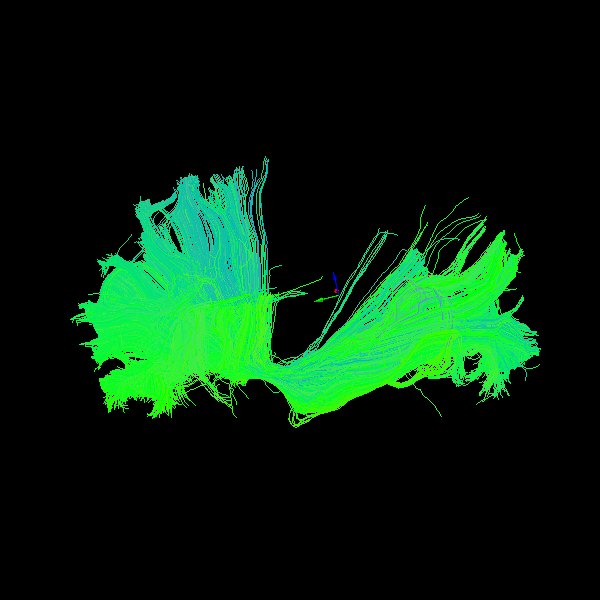

In [176]:
renpath=os.path.join(putdir, 'recognized_IFOF_L.png')
genren(rb_prisma_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## IFOF Trio

Test with a rescan of the same brain (different scanner/sequence)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


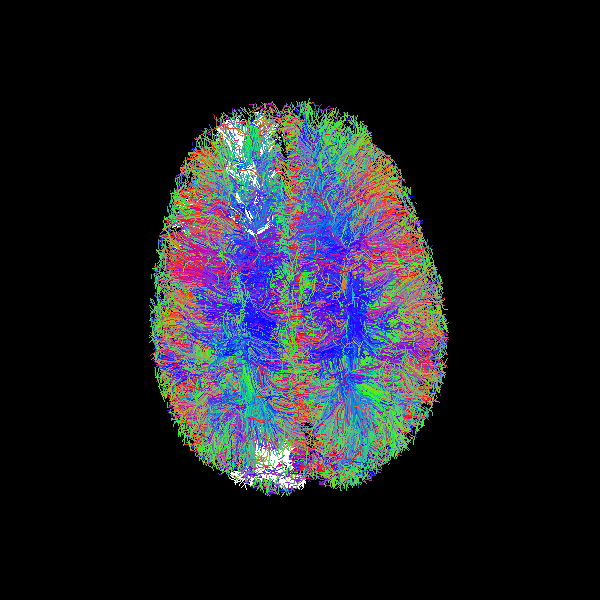

In [80]:
renpath=os.path.join(putdir, 'WB_IFOF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ifof_trio, putpath=renpath)
Image(renpath, width=400, height=400)

In [81]:
rb_rawtrio_ifof_L, cluster_map_trio = run_rb(t_sls_ifof_trio, wb_rawtrio_sls)

 Resampled to 20 points
 Size is 1033.419 MB
 Duration of resampling is 3.274 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 4515075 random streamlines
 Duration 284.735 sec. 

 Streamlines have 8431 centroids
 Total loading duration 0.004 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 5375 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 1.230 MB
 Duration of resampling is 0.013 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.235 sec. 

 Model bundle has 163 centroids
 Duration 0.249 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10382
 Duration 2.128 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.049
 Number of iterations 67
 Matrix size (400, 600)
[[ 0.982 -0.022  0.09   0.054]
 [ 0.023  0.986  0.    -1.234]
 [-0.09

#### Template IFOF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


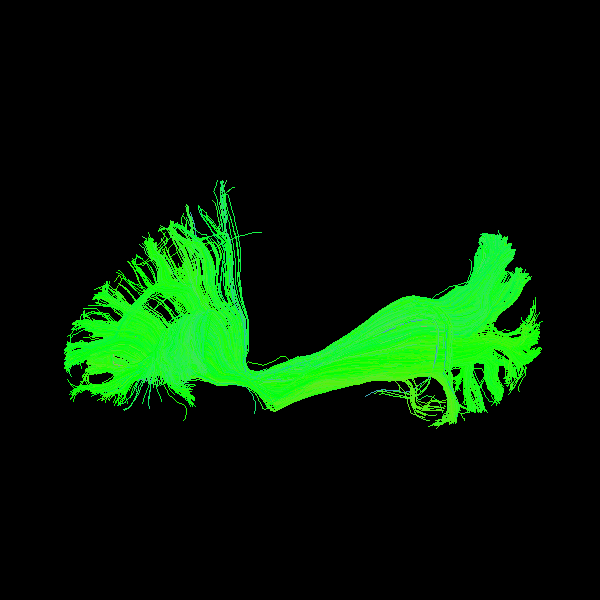

In [179]:
renpath2=os.path.join(putdir, 'template_IFOF_L.png')
genren(t_sls_ifof, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized IFOF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


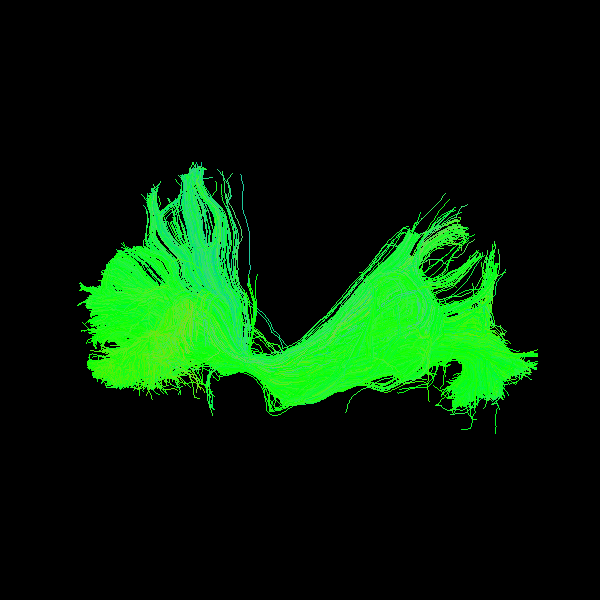

In [178]:
renpath=os.path.join(putdir, 'recognized_IFOF_L_RAW_TRIO.png')
genren(rb_rawtrio_ifof_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This one failed without preregistration.. With preregistration, however, it works quite well

# ILF

In [84]:
template_ilf = os.path.join(template_basepath, 'ILF_L.trk')

t_tg_ilf = loadtgm_newapi(template_ilf)

t_sls_ilf_prisma = t_tg_ilf.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_ilf_trio = t_tg_ilf.copy().apply_affine(xfm_temp2trio).streamlines

## ILF Prisma

In [93]:
rb_prisma_ilf_L, ig = run_rb(t_sls_ilf_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.007 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.159 sec. 

 Model bundle has 90 centroids
 Duration 0.167 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 9031
 Duration 0.738 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.464
 Number of iterations 66
 Matrix size (400, 600)
[[ 0.959  0.033  0.038  2.152]
 [-0.03   0.957 -0.084  4.037]
 [-0.041  0.083  0.956 -5.152]
 [ 0.     0.     0.     1.   ]]
[ 1.562  1.545  3.021  4.943  2.458 -1.774  0.961]
 Duration 18.545 sec. 

# Prune streamlines using the MDF distance
 Pruning 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


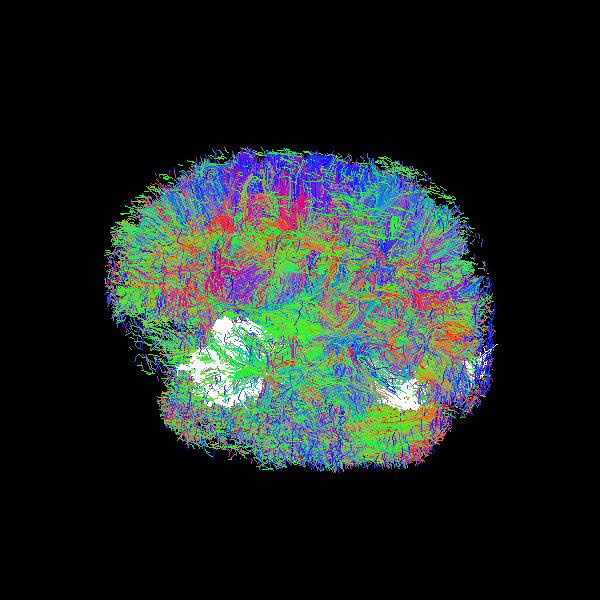

In [166]:
renpath=os.path.join(putdir, 'WB_ILF_L.png')
genren(wb_rawprisma_sls[::100], t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


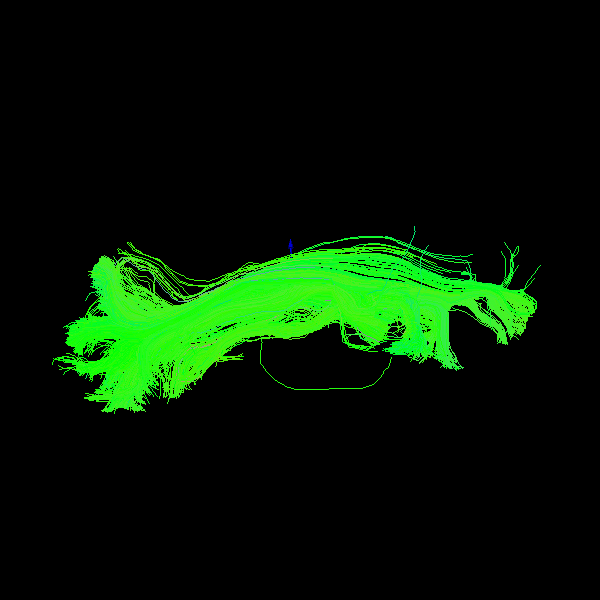

In [180]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized ILF Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


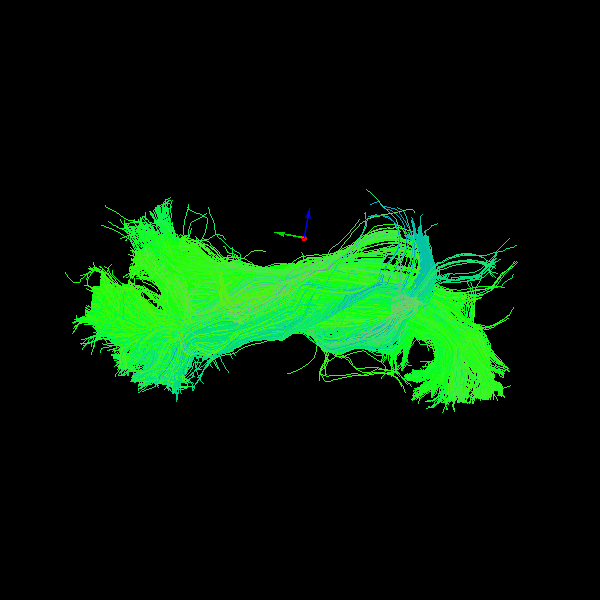

In [181]:
renpath=os.path.join(putdir, 'recognized_ILF_L.png')
genren(rb_prisma_ilf_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## ILF Trio

In [95]:
rb_trio_ilf_L, ig = run_rb(t_sls_ilf_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 3289 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.753 MB
 Duration of resampling is 0.006 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.165 sec. 

 Model bundle has 85 centroids
 Duration 0.171 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10190
 Duration 0.922 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.781
 Number of iterations 51
 Matrix size (400, 600)
[[ 0.881  0.096  0.108 -4.777]
 [-0.085  0.883 -0.094  0.101]
 [-0.117  0.082  0.881 -3.871]
 [ 0.     0.     0.     1.   ]]
[ 1.735  1.87   2.412  5.324  7.564 -5.504  0.892]
 Duration 14.870 sec. 

# Prune streamlines using the MDF distance
 Pruning

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


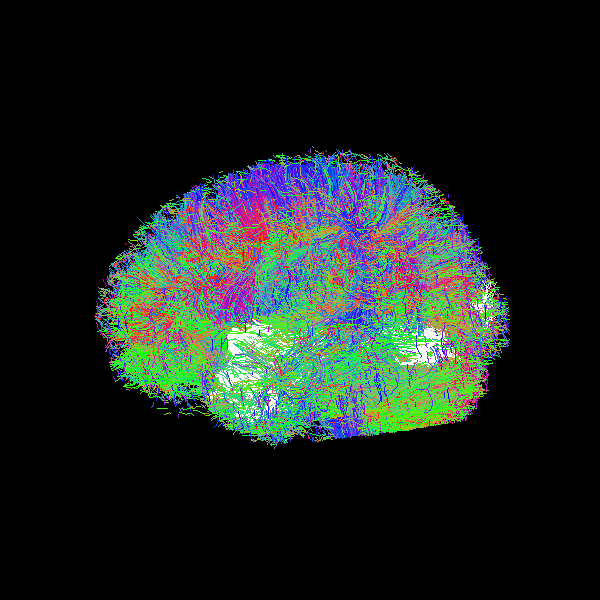

In [96]:
renpath=os.path.join(putdir, 'WB_ILF_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_ilf_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template ILF

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


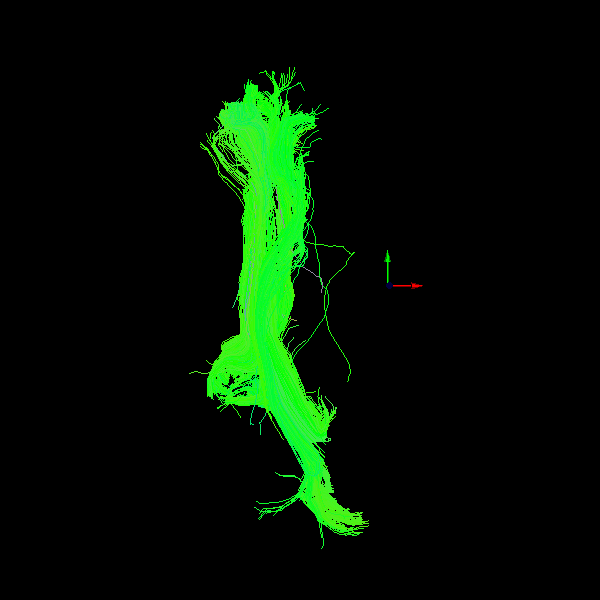

In [167]:
renpath=os.path.join(putdir, 'template_ILF_L.png')
genren(t_sls_ilf, putpath=renpath)
Image(renpath, width=400, height=400)

#### Recognized ILF Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


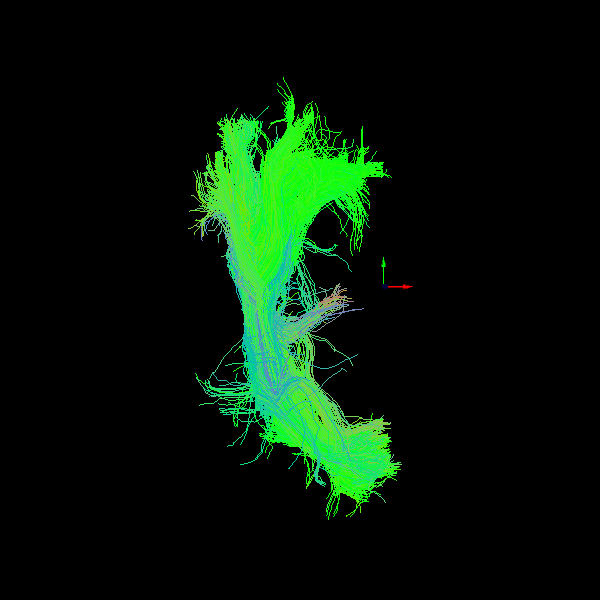

In [183]:
renpath=os.path.join(putdir, 'recognized_ILF_L_TRIO.png')
genren(rb_trio_ilf_L, putpath=renpath)
Image(renpath, width=400, height=400)

# Uncinate

In [99]:
template_unc = os.path.join(template_basepath, 'Uncinate_L.trk')

t_tg_unc = loadtgm_newapi(template_unc)
t_sls_unc_prisma = t_tg_unc.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_unc_trio = t_tg_unc.copy().apply_affine(xfm_temp2trio).streamlines

## Uncinate Prisma

In [104]:
rb_prisma_unc_L,ig = run_rb(t_sls_unc_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.031 sec. 

 Model bundle has 38 centroids
 Duration 0.033 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 13054
 Duration 0.475 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.120
 Number of iterations 63
 Matrix size (400, 600)
[[ 0.863 -0.143 -0.032  2.003]
 [ 0.14   0.862 -0.066 13.995]
 [ 0.043  0.059  0.873 -1.501]
 [ 0.     0.     0.     1.   ]]
[-3.617 -9.289 -3.091  3.896 -2.783  9.225  0.876]
 Duration 17.867 sec. 

# Prune streamlines using the MDF distance
 Pruning 

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


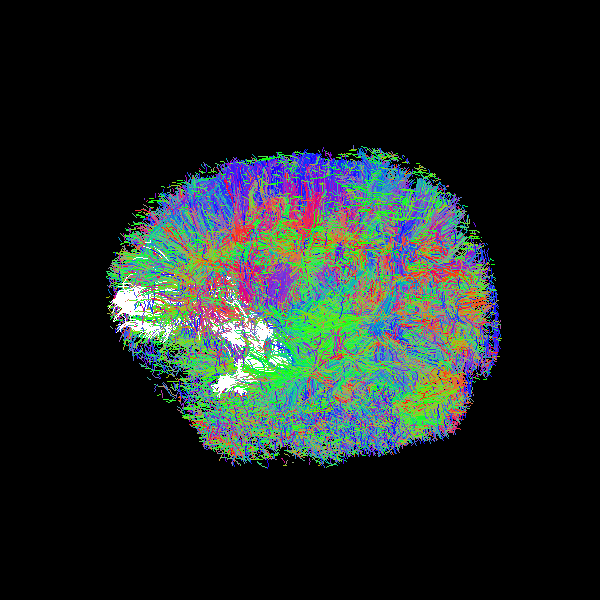

In [107]:
renpath=os.path.join(putdir, 'WB_UNC_L.png')
genren(wb_rawprisma_sls[::100], t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Uncinate Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


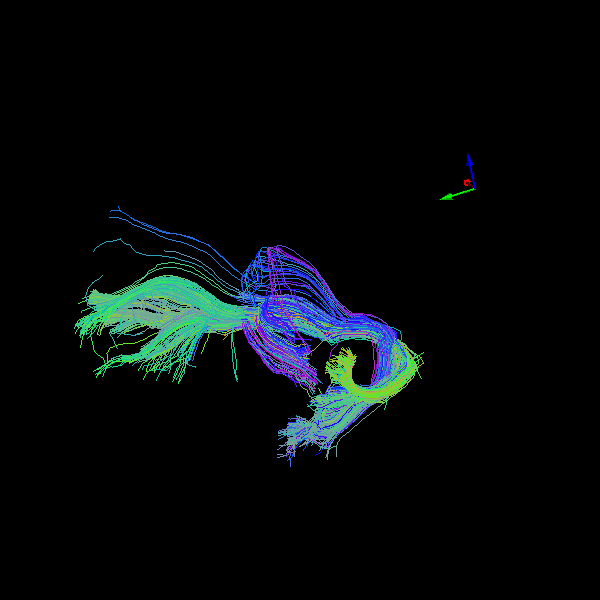

In [110]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


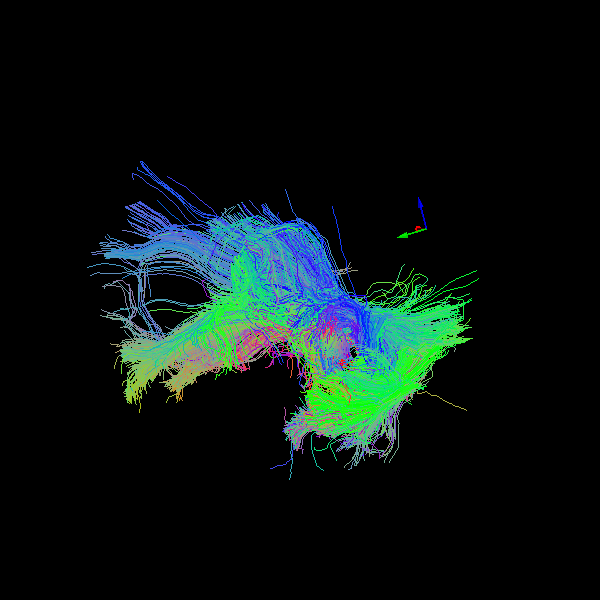

In [184]:
renpath=os.path.join(putdir, 'recognized_UNC_L.png')
genren(rb_prisma_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Uncinate

In [112]:
rb_trio_unc_L, ig = run_rb(t_sls_unc_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 878 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.201 MB
 Duration of resampling is 0.002 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.037 sec. 

 Model bundle has 33 centroids
 Duration 0.040 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 13782
 Duration 0.495 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.260
 Number of iterations 36
 Matrix size (400, 600)
[[ 0.869 -0.137 -0.064  0.956]
 [ 0.118  0.849 -0.208 12.617]
 [ 0.094  0.197  0.855  0.036]
 [ 0.     0.     0.     1.   ]]
[-2.743 -8.056 -0.732 12.967 -6.117  7.74   0.882]
 Duration 9.822 sec. 

# Prune streamlines using the MDF distance
 Pruning t

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


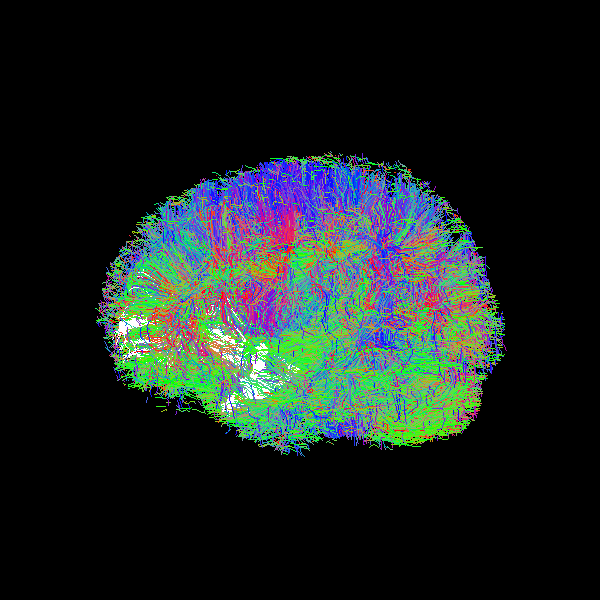

In [113]:
renpath=os.path.join(putdir, 'WB_UNC_L_TRIO.png')
genren(wb_rawtrio_sls[::100], t_sls_unc_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Uncinate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


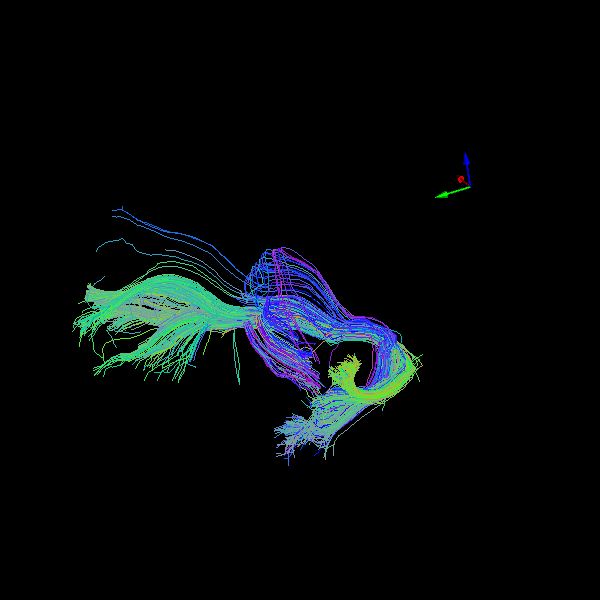

In [168]:
renpath=os.path.join(putdir, 'template_UNC_L.png')
genren(t_sls_unc_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Uncinate Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


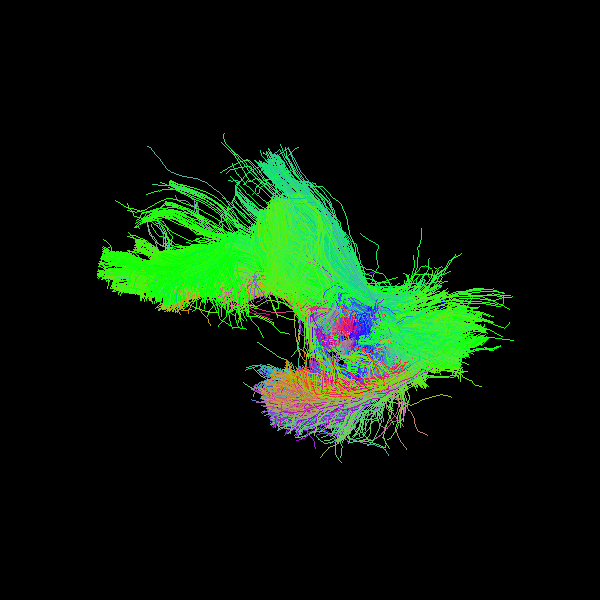

In [185]:
renpath=os.path.join(putdir, 'recognized_UNC_L_TRIO.png')
genren(rb_trio_unc_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Aslant

In [115]:
template_aslant = os.path.join(template_basepath, 'Aslant_L.trk')

t_tg_aslant = loadtgm_newapi(template_aslant)
t_sls_aslant_prisma = t_tg_aslant.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_aslant_trio = t_tg_aslant.copy().apply_affine(xfm_temp2trio).streamlines

## Prisma Aslant

In [116]:
rb_prisma_aslant_L, ig = run_rb(t_sls_aslant_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.003 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.045 sec. 

 Model bundle has 18 centroids
 Duration 0.049 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 12436
 Duration 0.382 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.333
 Number of iterations 61
 Matrix size (400, 600)
[[ 0.979 -0.002 -0.043 -0.658]
 [-0.002  0.976 -0.082 -2.379]
 [ 0.043  0.082  0.975 -2.03 ]
 [ 0.     0.     0.     1.   ]]
[ 3.923 -0.285  1.447  4.816 -2.508 -0.1    0.98 ]
 Duration 16.682 sec. 

# Prune streamlines using the MDF distance
 Pruning

#### Aslant Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


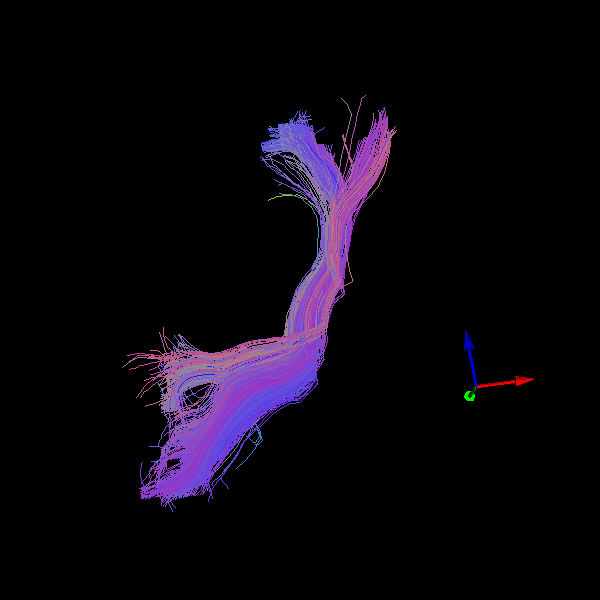

In [122]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


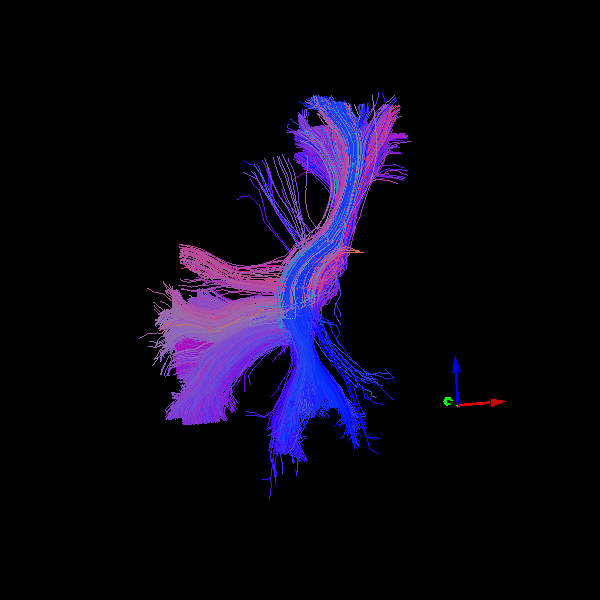

In [123]:
renpath=os.path.join(putdir, 'recognized_Aslant_L.png')
genren(rb_prisma_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Prisma

In [126]:
gold=glob(os.path.join(gs_prisma_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


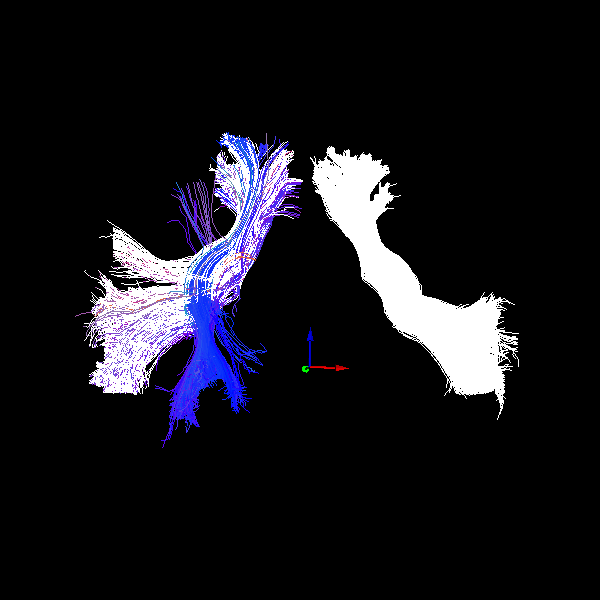

In [129]:
renpath=os.path.join(putdir, 'gold_Aslant_L_PRISMA_WHOLEBRAIN.png')
genren(rb_prisma_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

## Trio Aslant

In [131]:
rb_trio_aslant_L, ig = run_rb(t_sls_aslant_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 1792 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.410 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.059 sec. 

 Model bundle has 17 centroids
 Duration 0.063 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 8490
 Duration 0.372 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 4.786
 Number of iterations 63
 Matrix size (400, 600)
[[ 0.933 -0.041 -0.012 -1.122]
 [ 0.039  0.928 -0.1    0.893]
 [ 0.016  0.099  0.928  0.712]
 [ 0.     0.     0.     1.   ]]
[ 2.863 -2.281  0.528  6.102 -1.01   2.393  0.934]
 Duration 18.297 sec. 

# Prune streamlines using the MDF distance
 Pruning 

#### Template Aslant

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


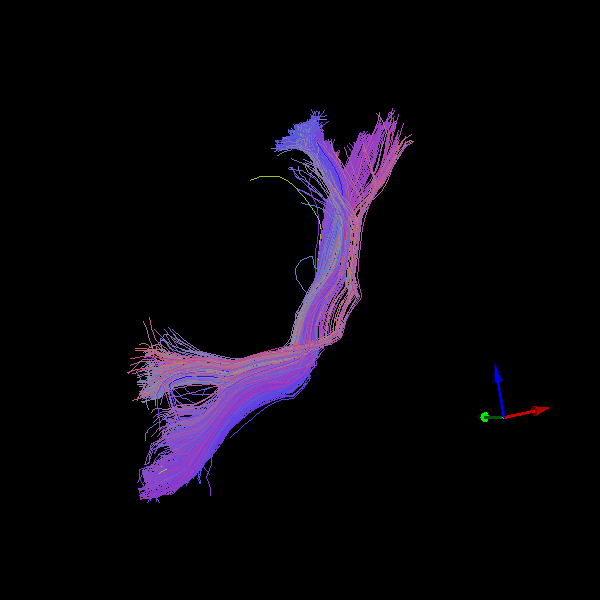

In [169]:
renpath=os.path.join(putdir, 'template_Aslant_L.png')
genren(t_sls_aslant_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Aslant Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


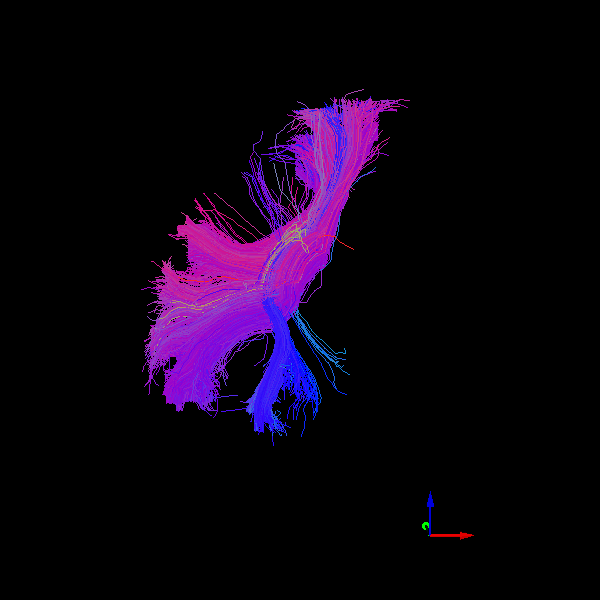

In [134]:
renpath=os.path.join(putdir, 'recognized_Aslant_L_TRIO.png')
genren(rb_trio_aslant_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Aslant Trio

In [132]:
gold=glob(os.path.join(gs_trio_path, 'Aslant_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


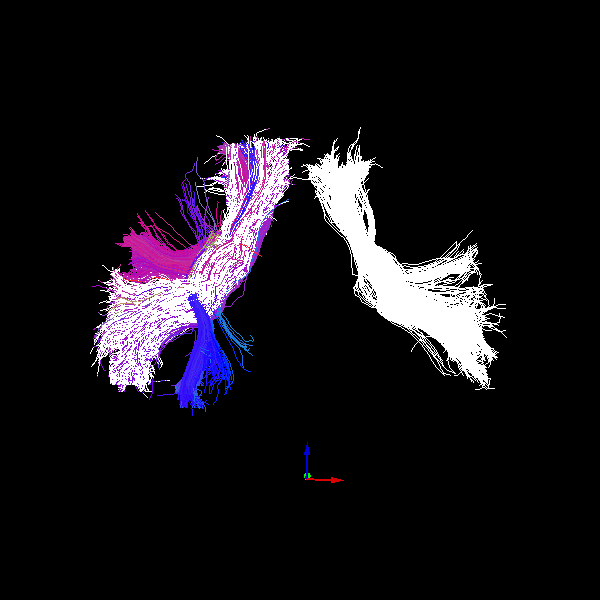

In [133]:
renpath=os.path.join(putdir, 'gold_Aslant_L_TRIO_WHOLEBRAIN.png')
genren(rb_trio_aslant_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# Arcuate

In [136]:
template_arcuate = os.path.join(template_basepath, 'Arcuate_L.trk')

t_tg_arcuate = loadtgm_newapi(template_arcuate)
t_sls_arcuate_prisma = t_tg_arcuate.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_arcuate_trio = t_tg_arcuate.copy().apply_affine(xfm_temp2trio).streamlines

## Arcuate Prisma

In [137]:
rb_prisma_arcuate_L, ig = run_rb(t_sls_arcuate_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.036 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.862 sec. 

 Model bundle has 331 centroids
 Duration 0.899 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 15875
 Duration 2.658 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.020
 Number of iterations 49
 Matrix size (400, 600)
[[ 1.063 -0.012  0.008  3.227]
 [ 0.012  1.063 -0.009  0.494]
 [-0.008  0.009  1.063 -3.934]
 [ 0.     0.     0.     1.   ]]
[-1.428 -2.272  0.705  0.48   0.417  0.666  1.063]
 Duration 13.582 sec. 

# Prune streamlines using the MDF distance
 Pruni

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


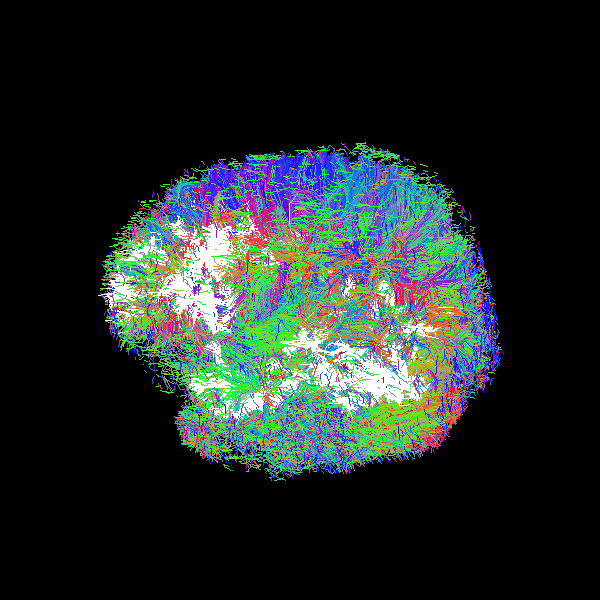

In [140]:
renpath=os.path.join(putdir, 'WB_Arcuate_L.png')
genren(wb_rawprisma_sls[::100], t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


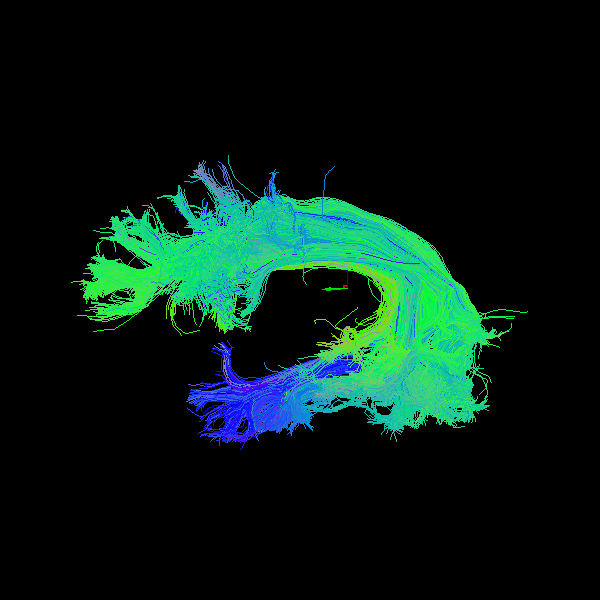

In [141]:
renpath=os.path.join(putdir, 'template_Arcuate_L.png')
genren(t_sls_arcuate_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


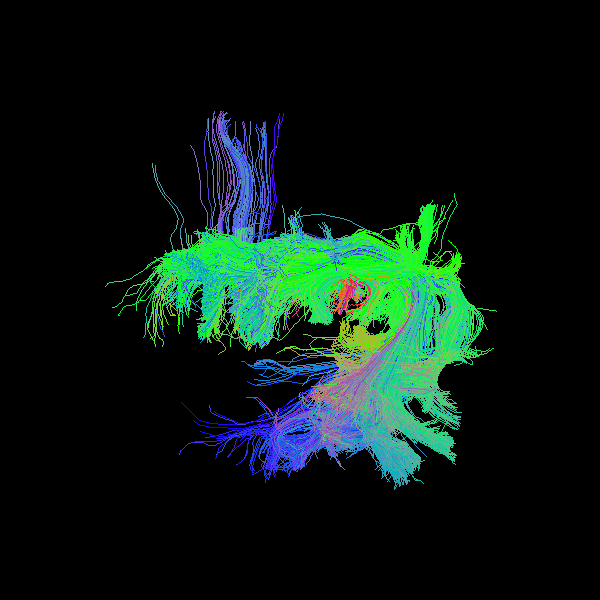

In [142]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_prisma_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

### Gold Standard Arcuate Prisma

In [143]:
gold=glob(os.path.join(gs_prisma_path, 'Arcuate_prob.trk'))[0]

gs_tg = loadtgm_newapi(gold)
gs_sls = gs_tg.streamlines

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


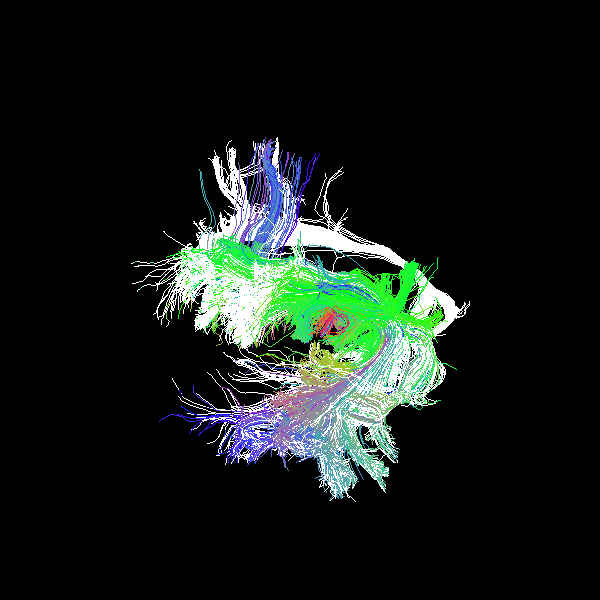

In [144]:
renpath=os.path.join(putdir, 'gold_Arcuate_L.png')
genren(rb_prisma_arcuate_L, gs_sls, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

This one has bundles belonging to multiple tracks: the Arcuate and also the SLF-ip (also called SLF 2&3 and Anterior SLF). Sub-bundles of these tracks are quite similar in shape; the STG projection of the Arcuate and the SLF3, in particular. 

## Arcuate Trio

In [186]:
rb_trio_arcuate_L, ig = run_rb(t_sls_arcuate_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.009 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 19566 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 4.478 MB
 Duration of resampling is 0.049 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 2.376 sec. 

 Model bundle has 313 centroids
 Duration 2.426 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 10461
 Duration 3.313 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.761
 Number of iterations 54
 Matrix size (400, 600)
[[ 1.036  0.014 -0.064  4.313]
 [-0.014  1.038  0.002 -3.169]
 [ 0.064 -0.001  1.036 -0.788]
 [ 0.     0.     0.     1.   ]]
[-0.644 -2.325 -0.048 -0.072 -3.544 -0.776  1.038]
 Duration 17.002 sec. 

# Prune streamlines using the MDF distance
 Pruni

#### Template Arcuate

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


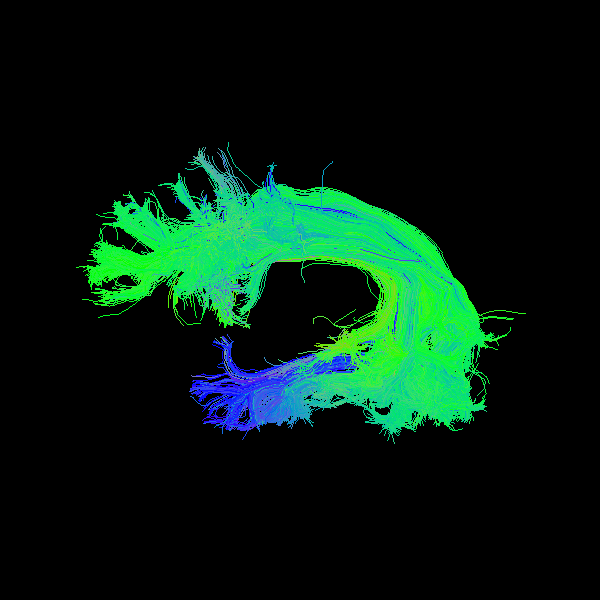

In [187]:
renpath=os.path.join(putdir, 'template_Arcuate_L_TRIO.png')
genren(t_sls_arcuate_trio, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized Arcuate Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


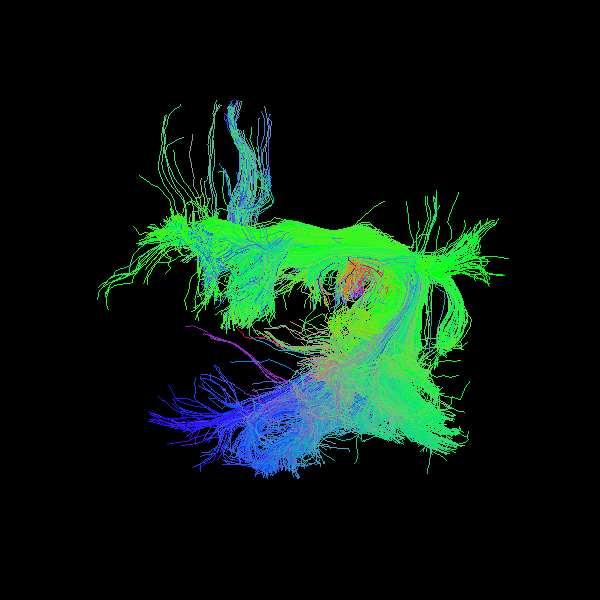

In [188]:
renpath=os.path.join(putdir, 'recognized_Arcuate_L.png')
genren(rb_trio_arcuate_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-IP

In [145]:
template_ip = os.path.join(template_basepath, 'SLF_IP_L.trk')

t_tg_slfip = loadtgm_newapi(template_ip)
t_sls_slfip_prisma = t_tg_slfip.copy().apply_affine(xfm_temp2prisma).streamlines

t_sls_slfip_trio = t_tg_slfip.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-IP Prisma

In [147]:
rb_prisma_slfip_L, ig = run_rb(t_sls_slfip_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.011 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.405 sec. 

 Model bundle has 182 centroids
 Duration 0.416 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 32154
 Duration 1.885 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 9.692
 Number of iterations 41
 Matrix size (400, 600)
[[ 1.035 -0.002 -0.008  2.823]
 [ 0.001  1.024 -0.146 -3.409]
 [ 0.008  0.146  1.024 -0.891]
 [ 0.     0.     0.     1.   ]]
[-6.112  3.869 -4.094  8.096 -0.428  0.052  1.035]
 Duration 12.206 sec. 

# Prune streamlines using the MDF distance
 Prunin

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


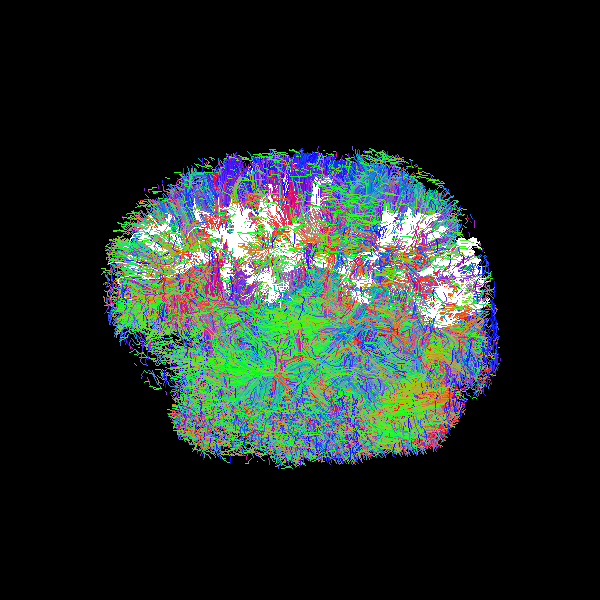

In [150]:
renpath=os.path.join(putdir, 'WB_SLFIP_L.png')
genren(wb_rawprisma_sls[::100], t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


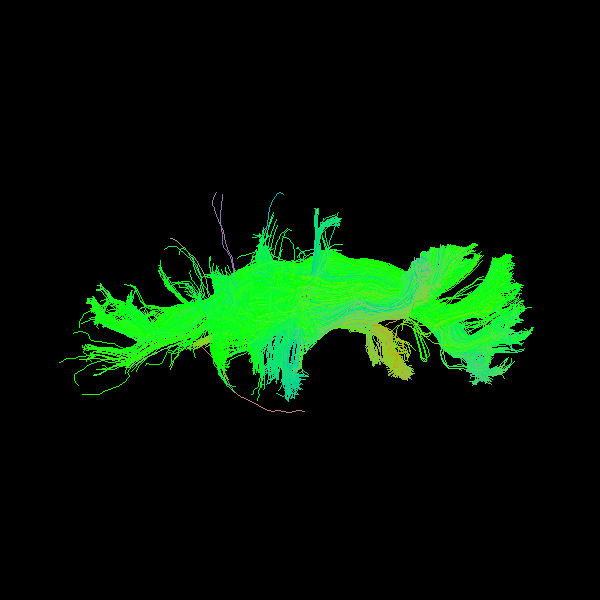

In [152]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


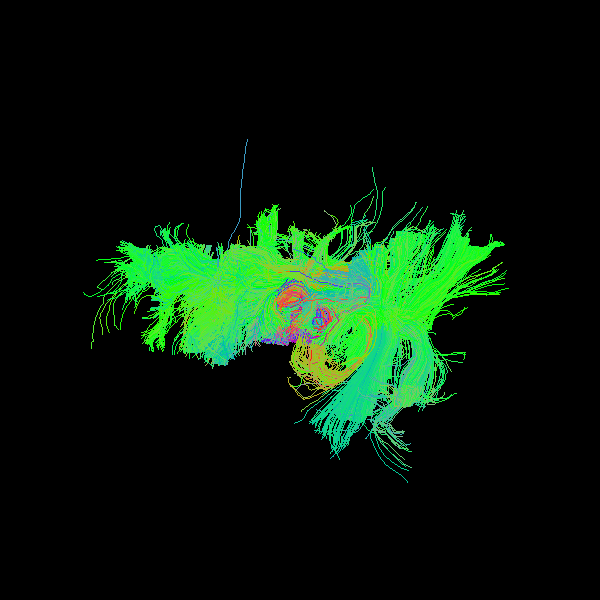

In [170]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L.png')
genren(rb_prisma_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

There is a little extra truncated Arcuate included in this SLF-IP model

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


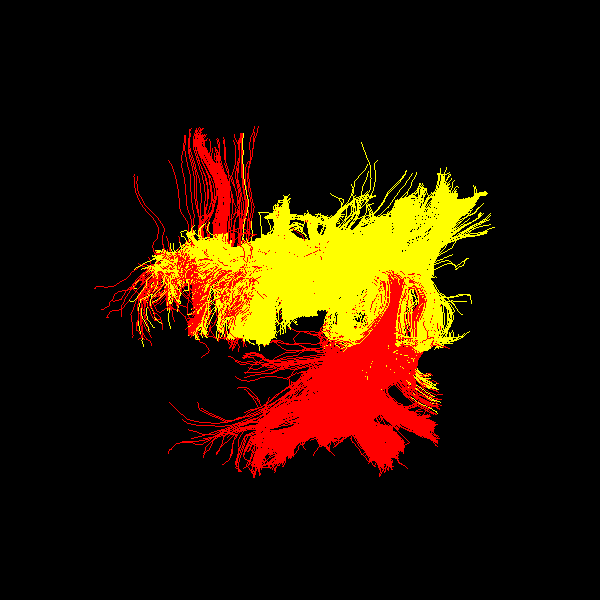

In [153]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFIP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slfip_L, putpath=renpath, show=True, colors=[(1,1,0),(1,0,0)])
Image(renpath, width=400, height=400)

## SLF-IP Trio

In [173]:
rb_trio_slfip_L, ig = run_rb(t_sls_slfip_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.002 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 9201 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 2.106 MB
 Duration of resampling is 0.020 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.514 sec. 

 Model bundle has 168 centroids
 Duration 0.535 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 14001
 Duration 2.006 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 8.607
 Number of iterations 66
 Matrix size (400, 600)
[[ 0.985  0.019  0.065 -2.215]
 [-0.007  0.972 -0.177 -1.581]
 [-0.068  0.176  0.969 -1.353]
 [ 0.     0.     0.     1.   ]]
[-0.777 -0.881 -2.81  10.29   3.934 -0.425  0.988]
 Duration 21.622 sec. 

# Prune streamlines using the MDF distance
 Prunin

#### SLF-IP Template

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


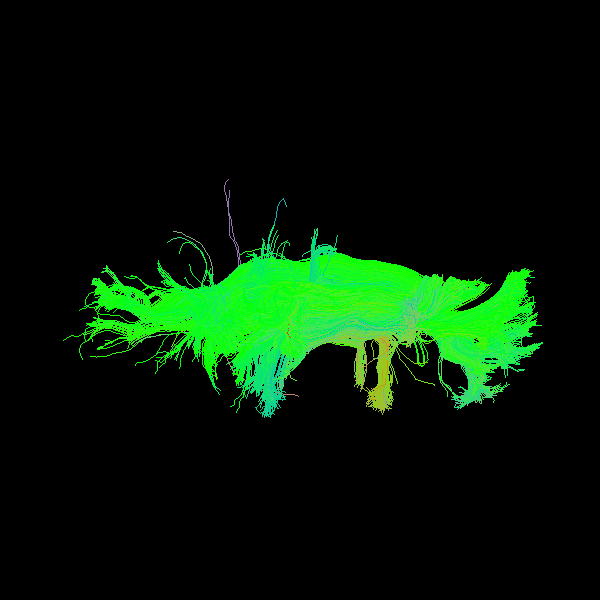

In [174]:
renpath=os.path.join(putdir, 'template_SLFIP_L.png')
genren(t_sls_slfip_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### SLF-IP Recognized Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


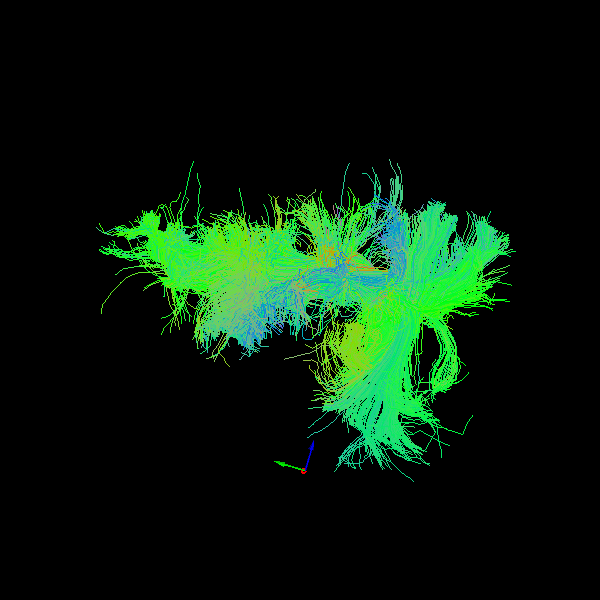

In [175]:
renpath=os.path.join(putdir, 'recognized_SLFIP_L_TRIO.png')
genren(rb_trio_slfip_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

# SLF-tp

In [154]:
template_tp = os.path.join(template_basepath, 'SLF-tp_L.trk')
t_tg_slftp = loadtgm_newapi(template_tp)
t_sls_slftp_prisma = t_tg_slftp.copy().apply_affine(xfm_temp2prisma).streamlines
t_sls_slftp_trio = t_tg_slftp.copy().apply_affine(xfm_temp2trio).streamlines

## SLF-tp Prisma

In [156]:
rb_prisma_slftp_L, ig = run_rb(t_sls_slftp_prisma, wb_rawprisma_sls, cluster_map_prisma)

Loading provided cluster map
 Streamlines have 6809 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.067 sec. 

 Model bundle has 31 centroids
 Duration 0.071 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 19338
 Duration 0.510 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 6.888
 Number of iterations 77
 Matrix size (400, 600)
[[ 0.823 -0.122  0.052 -9.629]
 [ 0.124  0.823 -0.035  0.033]
 [-0.047  0.043  0.831 -2.816]
 [ 0.     0.     0.     1.   ]]
[ 0.407 -1.275 -1.59   2.951  3.204  8.571  0.833]
 Duration 21.604 sec. 

# Prune streamlines using the MDF distance
 Pruning

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/dipy/viz/colormap.py:233: RuntimeWarning: invalid value encountered in true_divide
  orient = np.abs(orient / np.linalg.norm(orient))


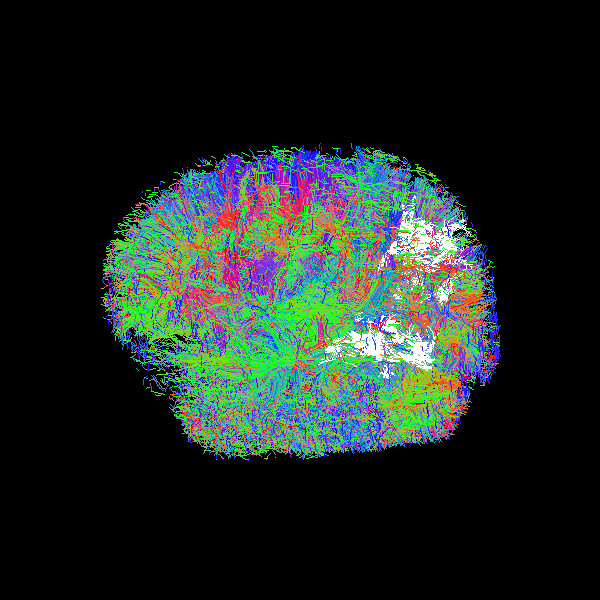

In [171]:
renpath=os.path.join(putdir, 'WB_SLFTP_L.png')
genren(wb_rawprisma_sls[::100], t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


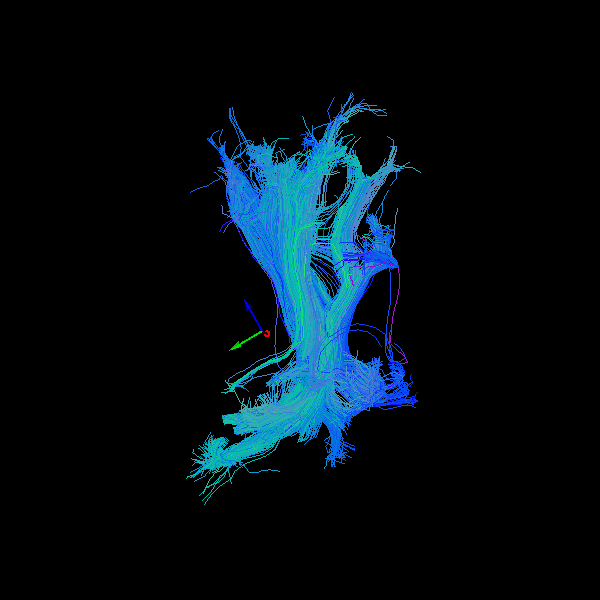

In [158]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Prisma

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


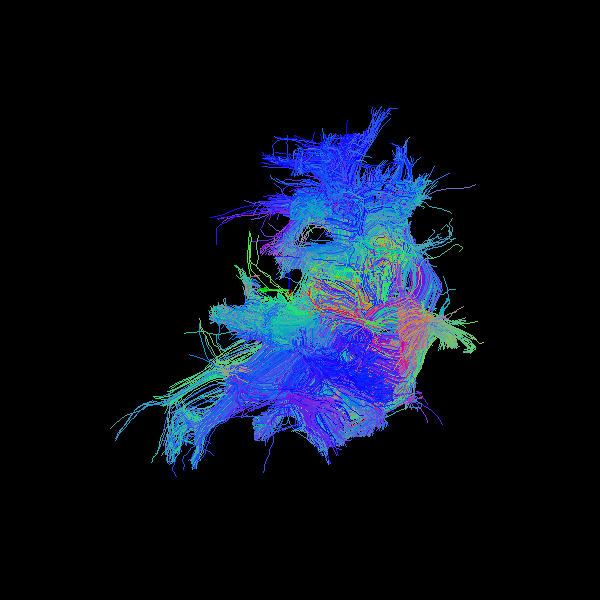

In [162]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L.png')
genren(rb_prisma_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


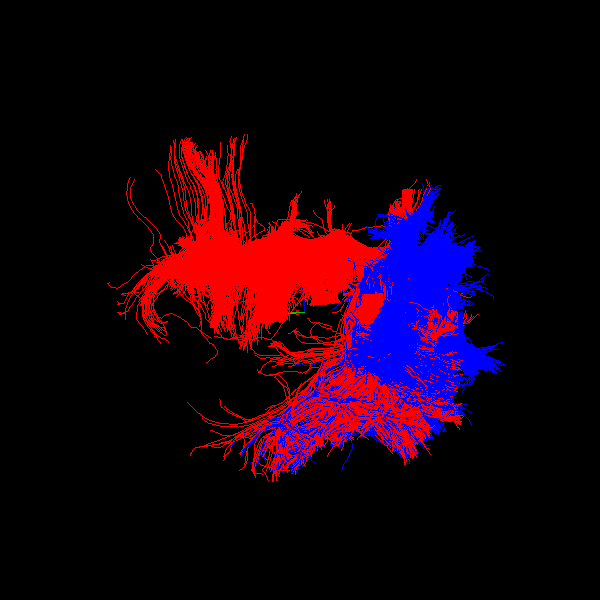

In [159]:
renpath=os.path.join(putdir, 'Arcuate_vs_SLFTP_L.png')
genren(rb_prisma_arcuate_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,0,0)])
Image(renpath, width=400, height=400)

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


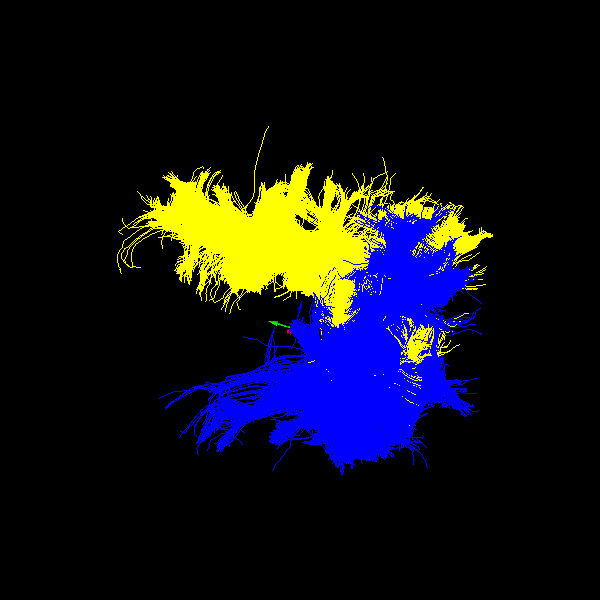

In [160]:
renpath=os.path.join(putdir, 'SLFIP_vs_SLFTP_L.png')
genren(rb_prisma_slfip_L, rb_prisma_slftp_L, putpath=renpath, show=True, colors=[(0,0,1),(1,1,0)])
Image(renpath, width=400, height=400)

## SLF-tp Trio

In [161]:
rb_trio_slftp_L, ig = run_rb(t_sls_slftp_trio, wb_rawtrio_sls, cluster_map_trio)

Loading provided cluster map
 Streamlines have 8431 centroids
 Total loading duration 0.003 sec. 

## Recognize given bundle ## 

# Cluster model bundle using QBx
 Model bundle has 2226 streamlines
 Distance threshold 5.000
 Resampled to 20 points
 Size is 0.509 MB
 Duration of resampling is 0.004 sec.
 QBX phase starting...
 Merging phase starting ...
 QuickBundlesX time for 500000 random streamlines
 Duration 0.063 sec. 

 Model bundle has 27 centroids
 Duration 0.068 sec. 

# Reduce search space
 Reduction threshold 10.000
 Reduction distance mdf
 Using MDF
 Number of neighbor streamlines 13432
 Duration 0.508 sec. 

# Local SLR of neighb_streamlines to model
 Square-root of BMD is 7.487
 Number of iterations 48
 Matrix size (400, 600)
[[  0.823  -0.01    0.075 -11.063]
 [  0.026   0.807  -0.177   0.462]
 [ -0.071   0.179   0.803   3.439]
 [  0.      0.      0.      1.   ]]
[ 1.616 -4.805 -4.816 12.536  4.936  1.785  0.826]
 Duration 15.494 sec. 

# Prune streamlines using the MDF d

#### Template SLF-tp

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


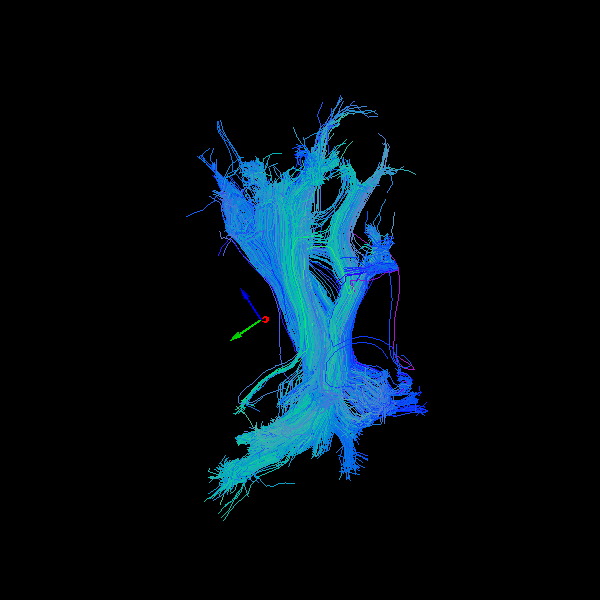

In [172]:
renpath=os.path.join(putdir, 'template_SLFTP_L.png')
genren(t_sls_slftp_prisma, putpath=renpath, show=True)
Image(renpath, width=400, height=400)

#### Recognized SLF-tp Trio

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


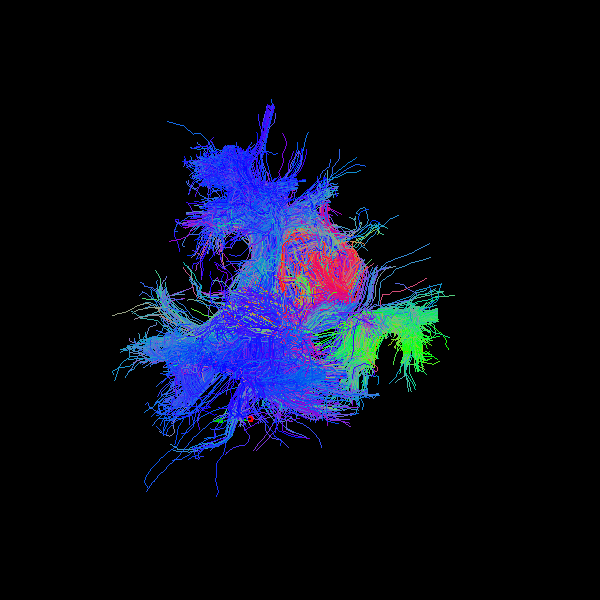

In [164]:
renpath=os.path.join(putdir, 'recognized_SLFTP_L_TRIO.png')
genren(rb_trio_slftp_L, putpath=renpath, show=True)
Image(renpath, width=400, height=400)